# Classification Part 1

Initially I looked through different questions in the questionaire and intuitively tried choosing ones that could be more or less influential for classifying political or economy preffernce.
This is very biased way of choosing questions.
Also the emphasis was on finding more numerical features rather than categorical. As I didn't know how to apporoach using them.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', 'raise')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import seaborn as sns

# Suppress warning about mixed data types in columns (change this later?)
import warnings
warnings.filterwarnings('ignore')

# Import Some of the useful defined functions
import useful_fun as uf
# object with different useful regions defined
regions = uf.Regions()

In [2]:
# Extract the the zipped csv data if it already hasn't been extracted 
import os.path
import zipfile

if not os.path.isfile('./data/LiTS_III_2016.csv'):
    with zipfile.ZipFile("./data/LiTS_III_2016.zip","r") as zip_ref:
        zip_ref.extractall("./data/")
else:
    print('File already present')

File already present


In [3]:
# Reading the dataframe
lits_2016_full = pd.read_csv('./data/LiTS_III_2016.csv') # data in the repo folder linux
# lits_2016 = pd.read_csv('LiTS III.csv')

I will try and use the following questions to make k-NN classifier for determening political / market inclination.

In [4]:
# Select only the columns we're interested in (can increase this as we go along)
good_cols = [
'country',#     'Country',                         # Categorical
'gender_pr',#   'Gender',                          # Categorical
'q204',#        'Internet Acess',                  # Categorical
'age_pr',#      'Age',                             # Numerical
'q223',#        'Monthly Income',                  # Numerical
'q109_1',#      'Education Level',                 # Numerical
'q203',#        'Books Growing Up',                # Numerical
'q403',#        'Trust in People',                 # Numerical
'q428',#        'Risktaking',                      # Numerical
'q901',#        'State of Health',                 # Numerical
'q904a',#       'News:Newspaper',                  # Numerical
'q904b',#       'News:Radio or Tv',                # Numerical
'q904c',#       'News:Printed Magazine',           # Numerical
'q904d',#       'News:In Depth TV / Radio',        # Numerical
'q904e',#       'News:Internet Email',             # Numerical
'q904f',#       'News:Family Friends',             # Numerical
'q904g',#       'News:Social Media',               # Numerical
'q905',#        'TV Time Yesterday',               # Numerical
'q412',#        'Political System',                # Categorical
'q411',#        'Economy Type',                    # Categorical
]
lits_2016_selected = lits_2016_full[good_cols]

# Give the columns new names
good_names = [
'Country',
'Gender',
'Internet Acess',
'Age',
'Monthly Income',
'Education Level',
'Books Growing Up',
'Trust in People',
'Risktaking',
'State of Health',
'News:Newspaper',
'News:Radio or Tv',
'News:Printed Magazine',
'News:In Depth TV / Radio',
'News:Internet Email',
'News:Family Friends',
'News:Social Media',
'TV Time Yesterday',
'Political System',
'Economy Type',
]
lits_2016_selected.columns = good_names


# Drop values nan values we cannot use
lits_2016_selected = lits_2016_selected.dropna()

# # Also set all the datatypes as int. (Makes operations with the dataframe more efficient)
lits_2016_selected.iloc[:,1:] = lits_2016_selected.iloc[:,1:].astype(int)
lits_2016_selected.head()

,Country,Gender,Internet Acess,Age,Monthly Income,Education Level,Books Growing Up,Trust in People,Risktaking,State of Health,News:Newspaper,News:Radio or Tv,News:Printed Magazine,News:In Depth TV / Radio,News:Internet Email,News:Family Friends,News:Social Media,TV Time Yesterday,Political System,Economy Type
0,Albania,2,3,47,-99,2,1,1,3,4,1,1,1,1,1,1,1,2,1,1
1,Albania,1,2,58,50000,2,1,1,3,3,6,6,6,6,6,6,6,5,1,1
2,Albania,1,3,40,-99,7,1,1,2,3,7,7,7,7,1,2,2,5,2,2
3,Albania,1,2,58,30000,2,1,1,2,3,2,2,2,2,1,2,1,2,2,2
4,Albania,2,1,28,-97,7,2,1,2,5,7,6,7,6,7,6,7,9,3,2


Let's look how balanced are the two questions up for use in classification. 
q412 - Political System;
q411 - Economy Type.

In [5]:
# Set different catergorical classes to strings to make it clearer
replace = {'Political System':{
 1: 'democratic',
 2: 'authoritarian',
 3: 'indifferent',
 -97 : 'dont know'},
 'Economy Type':{
 1: 'capitalist',
 2: 'social',
 3: 'indifferent',
 -97 : 'dont know'},
 'Gender':{
 1: 'men',
 2: 'women'}
 }
lits_2016_selected = lits_2016_selected.replace(replace);

democratic       0.503437
indifferent      0.222737
authoritarian    0.179478
dont know        0.094348
Name: Political System, dtype: float64

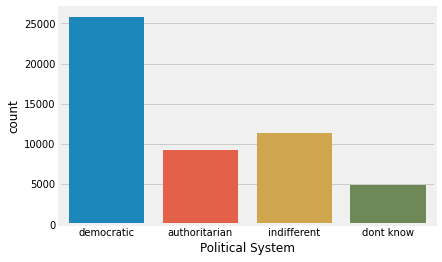

In [6]:
# Political System question
sns.countplot(lits_2016_selected['Political System']);
lits_2016_selected['Political System'].value_counts(normalize=True)

capitalist     0.365206
indifferent    0.274568
social         0.233829
dont know      0.126396
Name: Economy Type, dtype: float64

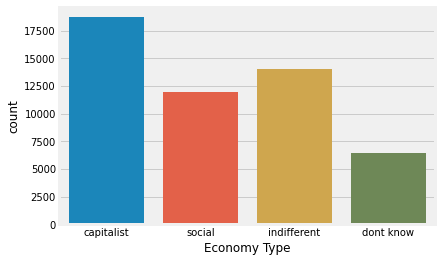

In [7]:
# Economy type question
sns.countplot(lits_2016_selected['Economy Type']);
lits_2016_selected['Economy Type'].value_counts(normalize=True)

In [8]:
# The following columns values will be used to as classes that we'll try to classify.

# class_col = 'Economy Type' 
class_col = 'Political System'
nearest_neighb = 7 # Number of nearest neighbours used to estimate the class

We can see that both sets of classes we propose to use are imbalanced. We'll need to address this.

### The features we have chosen are for the most part numerical, so we should remove the categorical answers from them
### Or possibly turn them into categorical answers

Remove the following:  
* -91 - difficult to say
* -99 - refusal
* -97 - don't know
* -98 - not applicable

In [9]:
# exclusion_criteria = [np.nan, -97, -99, -98, -91]
# meassure = lits_2016_selected.loc[:,'Age':'TV Time Yesterday'].columns

# lits_2016_selected_clean = uf.exclude_values(lits_2016_selected,meassure,exclusion_criteria)
lits_2016_selected_clean = lits_2016_selected.dropna()


In [10]:
percentage_after_cleaning = (lits_2016_selected_clean.shape[0]/lits_2016_selected.shape[0])*100
print('The percentage of the rows after cleaning {:2.2f} %, that is {} participants'.format(percentage_after_cleaning, lits_2016_selected_clean.shape[0]))

The percentage of the rows after cleaning 100.00 %, that is 51204 participants


As monthly income is per local currency, to use it in the classification we normalize it by the median in the country. The currency could be used in a variety of ways, it could be normalized by a differnt metric, like a mean or mod. Or could be used as is. Any of these could have different effects on how well this feature performs in classification.

In [11]:
# Median income values in each country
byIncome_mean = lits_2016_selected_clean.groupby('Country').median()['Monthly Income']

df = lits_2016_selected_clean

# Normalize by the median value of monthly income in each country
for country in byIncome_mean.index:
    df.loc[df['Country']==country,'Monthly Income'] = (df.loc[df['Country']==country,'Monthly Income']/byIncome_mean[country])*10


Adjust answers about internet acess. There are several options for why there's no internet access. To use this as a feature, the answers were adjusted to say the person, does or doesn't have internet access. Also make the categorical features to binary categorical features.

In [12]:
# 1 - Yes, 2,3,4 - Differnet variations of No
df.loc[df['Internet Acess']>1,'Internet Acess']= 0

df = df.drop(columns=['Country'])

# Make the categorical features into numerical binary features
# cat_to_num = ['Political System','Gender']
cat_to_num = ['Economy Type','Gender']
lits_2016_selected_clean = pd.get_dummies(df, columns = cat_to_num ,prefix_sep='_')

lits_2016_selected_clean.head()

,Internet Acess,Age,Monthly Income,Education Level,Books Growing Up,Trust in People,Risktaking,State of Health,News:Newspaper,News:Radio or Tv,...,News:Family Friends,News:Social Media,TV Time Yesterday,Political System,Economy Type_capitalist,Economy Type_dont know,Economy Type_indifferent,Economy Type_social,Gender_men,Gender_women
0,0,47,-0.02475,2,1,1,3,4,1,1,...,1,1,2,democratic,1,0,0,0,0,1
1,0,58,12.50000,2,1,1,3,3,6,6,...,6,6,5,democratic,1,0,0,0,1,0
2,0,40,-0.02475,7,1,1,2,3,7,7,...,2,2,5,authoritarian,0,0,0,1,1,0
3,0,58,7.50000,2,1,1,2,3,2,2,...,2,1,2,authoritarian,0,0,0,1,1,0
4,1,28,-0.02425,7,2,1,2,5,7,6,...,6,7,9,indifferent,0,0,0,1,0,1


Split the dataframe into training and test sets.

In [13]:
def train_test_valid(dataframe,train_prop = 7/10 ,valid_prop = 1/10):
    """
    Function splits the dataset into training, validation and tests sets and retruns        dataframes for each set.
    """
    participants = len(dataframe)
    num_train = int(round(participants * train_prop))
    num_valid = int(round(participants * (train_prop+valid_prop)))

    # Shuffle the dataframe
    dataframe = dataframe.sample(frac=1,replace=False)

    # Assign parts of the shuffled dataframe to training and test sets
    train = dataframe.iloc[:num_train,:].copy()
    valid = dataframe.iloc[num_train:num_valid,:].copy()
    test= dataframe.iloc[num_valid:,:].copy()

    # Separate the features from the output (X from Y)

    print("Training set:\t", len(train), "examples")
    print("Valid set:\t", len(valid), "examples")
    print("Test set:\t", len(test), "examples")
    return train, test, valid


# Split the selected features into a trainin, test and validatiion sets
train, test, valid = train_test_valid(lits_2016_selected_clean)




Training set:	 35843 examples
Valid set:	 5120 examples
Test set:	 10241 examples


### Run the classifier with the selected features
First check that the classifier works

In [14]:
train_not_balanced = train.copy()
test_not_balanced = test.copy()


# Check that the distances can be calculated 
sel_train_feat_with_dist = uf.distances(train_not_balanced, test_not_balanced.iloc[0],class_col).sort_values('Distance',ascending=False)

sel_train_feat_with_dist.head()

,Internet Acess,Age,Monthly Income,Education Level,Books Growing Up,Trust in People,Risktaking,State of Health,News:Newspaper,News:Radio or Tv,...,News:Social Media,TV Time Yesterday,Political System,Economy Type_capitalist,Economy Type_dont know,Economy Type_indifferent,Economy Type_social,Gender_men,Gender_women,Distance
6397,1,47,3.904516e+07,3,1,3,6,3,6,7,...,5,13,authoritarian,0,0,1,0,1,0,3.904515e+07
7397,0,50,3.904516e+07,4,2,2,8,2,4,7,...,6,3,indifferent,0,0,1,0,1,0,3.904515e+07
33969,1,32,1.132075e+03,7,3,3,2,3,2,7,...,7,0,democratic,1,0,0,0,1,0,1.121485e+03
851,1,28,1.000000e+03,3,4,3,6,2,7,7,...,1,4,democratic,1,0,0,0,0,1,9.894986e+02
1570,1,35,7.526882e+02,7,5,2,10,2,1,4,...,7,0,democratic,1,0,0,0,0,1,7.421293e+02


In [15]:
# What is the actual example classification
print('First test row classification: {}'.format(test_not_balanced[class_col].iloc[0]))

# Prediction based on the classification
print('5-NN classification: {}'.format(uf.predict_nn(test_not_balanced.iloc[0], train_not_balanced, nearest_neighb, class_col)))

First test row classification: indifferent
5-NN classification: indifferent


In [16]:
# Run the classifier on all the test values
test_not_balanced['Guesses'] = test_not_balanced.apply(uf.predict_nn,args=(train_not_balanced, nearest_neighb, class_col), axis = 1)
test_not_balanced.head()

,Internet Acess,Age,Monthly Income,Education Level,Books Growing Up,Trust in People,Risktaking,State of Health,News:Newspaper,News:Radio or Tv,...,News:Social Media,TV Time Yesterday,Political System,Economy Type_capitalist,Economy Type_dont know,Economy Type_indifferent,Economy Type_social,Gender_men,Gender_women,Guesses
3425,0,42,10.666667,3,1,3,6,3,2,3,...,6,3,indifferent,0,0,1,0,1,0,indifferent
27474,0,86,-0.088182,4,2,2,3,3,6,7,...,1,2,authoritarian,0,0,1,0,1,0,democratic
27959,1,67,-0.090000,4,2,-91,4,2,1,6,...,6,1,indifferent,0,0,1,0,0,1,indifferent
36798,1,72,-0.618750,8,2,2,6,4,6,6,...,1,6,democratic,0,0,1,0,1,0,democratic
39274,1,20,16.000000,5,4,3,4,3,2,4,...,7,2,authoritarian,0,0,0,1,1,0,democratic


### Let's see what was the acuraccy. 

In [17]:
def calculate_accuracy(resultsDF,Output):
    """
    Function calculates and prints class and total accuracy given the dataframe
    and the output class column
    """
    # Create a column, that indicates if the guess was correct
    resultsDF['Correct'] = resultsDF['Guesses'] == resultsDF[Output]
    

    # Count correct, incorrect guesses per class
    accuracy = resultsDF.value_counts(['Guesses', 'Correct'])
    
    # For each class print the achieved accuaracy
    cat = np.unique(resultsDF[Output])
    for value in cat:
        # Calculate accuracy fot this class
        achieved_accuracy =  (accuracy[value][True]/accuracy[value].sum())*100
        print('{} - {:2.2f}%:'.format(value,achieved_accuracy))

    # Calculate and print total accuracy
    accuracy = resultsDF.value_counts('Correct')
    achieved_accuracy =  (accuracy[True]/accuracy.sum())*100
    print('\nTotal Accuracy - {:2.2f}%:'.format(achieved_accuracy))



# Calculate and print class and total accuracy.
calculate_accuracy(test_not_balanced,class_col)

authoritarian - 27.12%:
democratic - 55.47%:
dont know - 36.12%:
indifferent - 35.12%:

Total Accuracy - 48.46%:


### The accuracy is quite low. Let's try and balance the dataset, and then see how well this performs

democratic       0.503437
indifferent      0.222737
authoritarian    0.179478
dont know        0.094348
Name: Political System, dtype: float64

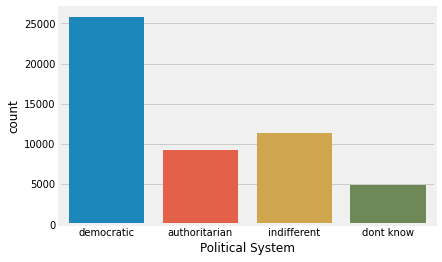

In [18]:
# Economy type question
sns.countplot(lits_2016_selected_clean[class_col]);
lits_2016_selected_clean[class_col].value_counts(normalize=True)

### First let's balance without replacing

In [19]:
def balance_df(dataframe,Output,bootstrap = False):
    """
    Passing in the dataframe and the output category, returns a dataframe with a 
    balanced number of output clases
    """
    categories = np.unique(dataframe[Output]) # the unique classes

    balancedDf = pd.DataFrame()
    if bootstrap == False:
        # Find the maximum number of rows without replacement
        max_len = dataframe[Output].value_counts(ascending=True)[0]

        for cat in categories:
            df = dataframe[dataframe[Output]==cat].copy()
            df = df.sample(frac=1,replace=False).iloc[:max_len,:]
            balancedDf = pd.concat([balancedDf,df])
    else:
        # Find the maximum number of rows with replacement
        max_len = dataframe[Output].value_counts()[0]
        min_len = dataframe[Output].value_counts()[-1]
        fraction = round(max_len/min_len)

        for cat in categories:
            df = dataframe[dataframe[Output]==cat].copy()
            df = df.sample(frac=fraction,replace=True).iloc[:max_len,:]
            balancedDf = pd.concat([balancedDf,df])
    return balancedDf


# Copy original split into new dataframes to not mix up guess outputs
train_balanced_not_boot = train.copy()
test_balanced_not_boot = test.copy()

# Balance the training dataset, by equaling the dataset size to the smallest size of the claseses.
train_not_bootstrap = balance_df(train_balanced_not_boot,class_col)

In [20]:
# Here you can see that the 'dont know' class has the lowest representation in the training data set
train.value_counts(class_col)

Political System
democratic       18003
indifferent       7953
authoritarian     6463
dont know         3424
dtype: int64

In [21]:
# Here you can see that after balancing without replacement all classes have equal number of rows equal to the lowest number of rows in the original training set dataframe.

train_not_bootstrap.value_counts(class_col)

Political System
authoritarian    3424
democratic       3424
dont know        3424
indifferent      3424
dtype: int64

In [22]:
#  Run the classifier on all the test values from the balanced training dataset
test_balanced_not_boot['Guesses'] = test_balanced_not_boot.apply(uf.predict_nn,args=(train_not_bootstrap, nearest_neighb, class_col), axis = 1)

# Check for accuracy
calculate_accuracy(test_balanced_not_boot,class_col)

KeyboardInterrupt: 

### Accuracy has not improved. Let's try now with bootstrapping

In [36]:
# Copy original split into new dataframes to not mix up guess outputs
train_balanced_boot = train.copy()
test_balanced_boot = test.copy()

# Balance the training dataset, by equaling the dataset size to the smallest size of the claseses.
train_balanced_boot = balance_df(train_balanced_boot,class_col,bootstrap=True)

# Here you can see that after balancing with replacement all classes have equal number of rows equal to the highest number of rows in the original training set dataframe.

train_balanced_boot.value_counts(class_col)

Political System
authoritarian    18183
democratic       18183
indifferent      18183
dont know        16740
dtype: int64

In [37]:
#  Run the classifier on all the test values from the balanced training dataset
test_balanced_boot['Guesses'] = test_balanced_boot.apply(uf.predict_nn,args=(train_balanced_boot, nearest_neighb, class_col), axis = 1)

# Check for accuracy
calculate_accuracy(test_balanced_boot,class_col)

authoritarian - 23.06%:
democratic - 60.64%:
dont know - 20.49%:
indifferent - 29.40%:

Total Accuracy - 34.62%:
